In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


In [2]:
df = pd.read_csv("/kaggle/input/titanic/train.csv").drop("PassengerId", axis=1)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
survivors = df["Survived"] == 0
df[survivors].describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,549.0,549.000000,424.000000,549.000000,549.000000,549.000000
mean,0.0,2.531876,30.626179,0.553734,0.329690,22.117887
std,0.0,0.735805,14.172110,1.288399,0.823166,31.388207
min,0.0,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.0,2.000000,21.000000,0.000000,0.000000,7.854200
50%,0.0,3.000000,28.000000,0.000000,0.000000,10.500000
75%,0.0,3.000000,39.000000,1.000000,0.000000,26.000000
max,0.0,3.000000,74.000000,8.000000,6.000000,263.000000


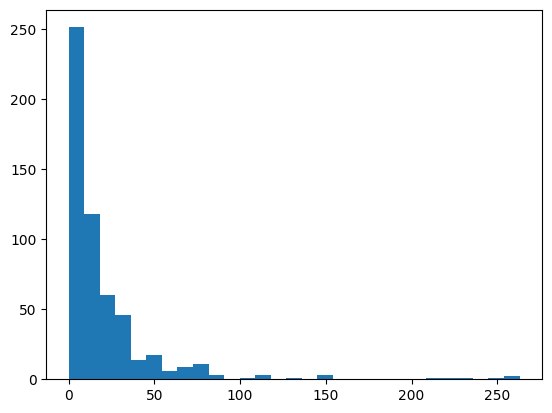

In [4]:
fare_bins = np.linspace(df[survivors]["Fare"].min(), df[survivors]["Fare"].max(), 30)
plt.hist(df[survivors]["Fare"], fare_bins);

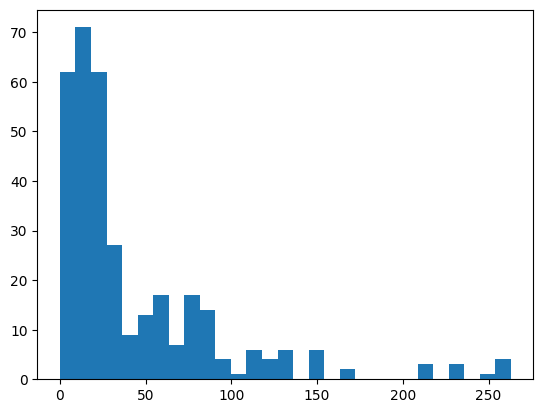

In [5]:
fare_bins = np.linspace(df[~survivors]["Fare"].min(), df[survivors]["Fare"].max(), 30)
plt.hist(df[~survivors]["Fare"], fare_bins);

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [7]:
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [8]:
x = df.drop("Survived", axis=1)
y = df["Survived"]

def extract_ticket_number(ticket):
        match = re.search(r'\d+', ticket)
        return match.group() if match else None

def extract_surname_title(name):
        surname, rest = name.split(', ', 1)
        title = rest.split(' ')[0]
        return pd.Series([surname, title])
    

def feature_engeneering(x):
    
    x["Ticket_number"] = x["Ticket"].apply(extract_ticket_number)
    x[['Cabin_Prefix', 'Cabin_Number']] = x['Cabin'].str.extract(r'([A-Za-z]+)(\d+)')
    x[['Surname', 'Title']] = x['Name'].apply(extract_surname_title)
    
    age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
    age_labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90']
    df['Age_Category'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)
    
    
    x["SibSp"] = x["SibSp"].astype("str")
    x["Pclass"] = x["Pclass"].astype("str")
    x["Parch"] = x["Parch"].astype("str")
    x = x.drop(["Ticket", "Cabin", "Name", "Title"], axis=1)

    return x

In [9]:
x = feature_engeneering(x)
x_cat_col = x.select_dtypes(include="object").columns
x_num_col = x.select_dtypes(exclude="object").columns

encoder_cat = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ("imputer", SimpleImputer(strategy="constant", fill_value=0, add_indicator=True))
])

encoder_num = Pipeline([
    ("scaler", StandardScaler()),
    ("imputer", KNNImputer(n_neighbors=40, add_indicator=True))
])

transformer = ColumnTransformer([
    ("cat", encoder_cat, x_cat_col),
    ("num", encoder_num, x_num_col)
])

In [10]:
model_gbc = Pipeline([
    ("transformer", transformer),
    ("gbc", GradientBoostingClassifier())
])

model_rfc = Pipeline([
    ("transformer", transformer),
    ("rfc", RandomForestClassifier())
])

model_xgbc = Pipeline([
    ("transformer", transformer),
    ("xgb", XGBClassifier())
])

# model_lgbmc = Pipeline([
#     ("transformer", transformer),
#     ("lgbmc", LGBMClassifier())
# ])

model_lreg = Pipeline([
    ("transformer", transformer),
    ("lreg", LogisticRegression(max_iter=6000))
])

param_grid_gbc = {
    "gbc__n_estimators": [50, 100, 200],
    "gbc__learning_rate": [0.01, 0.1, 0.2],
    "gbc__max_depth": [3, 5, 7]
}

param_grid_rfc = {
    "rfc__n_estimators": [50, 100, 200],
    "rfc__max_depth": [None, 10, 20],
    "rfc__min_samples_split": [2, 5, 10]
}

param_grid_xgbc = {
    "xgb__n_estimators": [50, 100, 200],
    "xgb__learning_rate": [0.01, 0.1, 0.2],
    "xgb__max_depth": [3, 5, 7]
}

# param_grid_lgbmc = {
#     "lgbmc__n_estimators": [50, 100, 200],
#     "lgbmc__learning_rate": [0.01, 0.1, 0.2],
#     "lgbmc__num_leaves": [31, 63, 127]
# }

param_grid_lreg = {
    'lreg__C': [0.0001, 0.01, 0.1, 1, 10, 100],
    'lreg__penalty': ['l1', 'l2'],
    'lreg__solver': ['saga']
}

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.5, random_state=42)

models = {
    "Logistic Regression": model_lreg,
    "Gradient Boosting Classifier": model_gbc,
    "Random Forest Classifier": model_rfc,
    "XGBoost Classifier": model_xgbc,
#     "LightGBM Classifier": model_lgbmc
    
}

param_grids = {
    "Logistic Regression": param_grid_lreg,
    "Gradient Boosting Classifier": param_grid_gbc,
    "Random Forest Classifier": param_grid_rfc,
    "XGBoost Classifier": param_grid_xgbc,
#     "LightGBM Classifier": param_grid_lgbmc
    
}

best_scores = {}

for model_name, model_pipeline in models.items():
    print(f"Performing Grid Search for {model_name}")

    grid_search = GridSearchCV(model_pipeline, param_grids[model_name], cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(x_train, y_train)
   
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    best_scores[model_name] = accuracy
    
best_scores

Performing Grid Search for Logistic Regression
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Performing Grid Search for Gradient Boosting Classifier
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Performing Grid Search for Random Forest Classifier
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Performing Grid Search for XGBoost Classifier
Fitting 5 folds for each of 27 candidates, totalling 135 fits


{'Logistic Regression': 0.7937219730941704,
 'Gradient Boosting Classifier': 0.8139013452914798,
 'Random Forest Classifier': 0.7982062780269058,
 'XGBoost Classifier': 0.804932735426009}

In [12]:
param_grid_rfc = {
    "rfc__n_estimators": [10, 50, 100, 200],
    "rfc__max_depth": [None, 5, 10, 15, 20],
    "rfc__min_samples_split": [2, 5, 10]
}

grid = GridSearchCV(estimator=model_rfc, param_grid=param_grid_rfc, scoring="accuracy", cv=5, n_jobs=-1, verbose=1).fit(x_train, y_train)
print(f"Best model is: {str(grid.best_estimator_.named_steps['rfc'])}, whose accuracy on test is found to be: {accuracy_score(y_test, grid.best_estimator_.predict(x_test))}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best model is: RandomForestClassifier(), whose accuracy on test is found to be: 0.7937219730941704


In [13]:
params = grid.best_estimator_["rfc"].get_params()

model_rfc = Pipeline([
    ("transformer", transformer),
    ("rfc", RandomForestClassifier(**params))
])
model = model_rfc.fit(x, y)



In [14]:
test = pd.read_csv("/kaggle/input/titanic/test.csv")
test_transformed = feature_engeneering(test)

prediction = model.predict(test_transformed)
submission_dataframe = pd.DataFrame({"PassengerId": test["PassengerId"], "Survived": prediction})
submission_dataframe.to_csv('submission.csv', index=False)